<a href="https://colab.research.google.com/github/nalsadi/DefImageRegMnist/blob/main/pocSegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple example for deep-learning-based non-rigid image registration
with the MNIST dataset.

**README:** If the below error occurs, run the whole notebook again (Ctrl+F9).


```
ValueError: tf.function-decorated function tried to create variables on non-first call.
```



In [227]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)
print(tf.keras.backend.image_data_format())

2.7.0
channels_last


Loss functions

In [228]:
@tf.function
def mse_loss(static, moving):
    """Computes the mean squared error (MSE) loss.

    Currently, only 4-D inputs are supported.

    Parameters
    ----------
    static : tf.Tensor, shape (N, H, W, C)
        The static image to which the moving image is aligned.
    moving : tf.Tensor, shape (N, H, W, C)
        The moving image, the same shape as the static image.

    Returns
    -------
    loss : tf.Tensor, shape ()
        Mean squared error between the static and the moving images,
        averaged over the batch.
    """
    loss = tf.reduce_mean(tf.square(moving - static))  # shape ()
    return loss

In [229]:
@tf.function
def ncc_loss(static, moving):
    """Computes the normalized cross-correlation (NCC) loss.

    Currently, only 4-D inputs are supported.

    Parameters
    ----------
    static : tf.Tensor, shape (N, H, W, C)
        The static image to which the moving image is aligned.
    moving : tf.Tensor, shape (N, H, W, C)
        The moving image, the same shape as the static image.

    Returns
    -------
    loss : tf.Tensor, shape ()
        Normalized cross-correlation loss between the static and the
        moving images, averaged over the batch. Range is [-1.0, 1.0].
        The best value is -1 (perfect match) and the worst is 1.

    References
    ----------
    .. [1] `Wikipedia entry for the Cross-correlation
           <https://en.wikipedia.org/wiki/Cross-correlation>`_
    """
    eps = tf.constant(1e-9, 'float32')

    static_mean = tf.reduce_mean(static, axis=[1, 2], keepdims=True)
    moving_mean = tf.reduce_mean(moving, axis=[1, 2], keepdims=True)
    # shape (N, 1, 1, C)

    static_std = tf.math.reduce_std(static, axis=[1, 2], keepdims=True)
    moving_std = tf.math.reduce_std(moving, axis=[1, 2], keepdims=True)
    # shape (N, 1, 1, C)

    static_hat = (static - static_mean)/(static_std + eps)
    moving_hat = (moving - moving_mean)/(moving_std + eps)
    # shape (N, H, W, C)

    ncc = tf.reduce_mean(static_hat * moving_hat)  # shape ()
    loss = -ncc
    return loss

Define the model 

In [230]:
def simple_cnn(input_shape=(32, 32, 2)):
    """Creates a 2-D convolutional encoder-decoder network.

    Parameters
    ----------
    input_shape : sequence of ints, optional
        Input data shape of the form (H, W, C). Default is (32, 32, 2).

    Returns
    -------
    model
        An instance of Keras' Model class.

    Notes
    -----
    Given a concatenated pair of static and moving images as input, the
    CNN computes a dense displacement field that is used to warp the
    moving image to match with the static image.

    The number of channels in the output (displacement field) is equal
    to the dimensionality of the input data. For 3-D volumes, it is 3,
    and for 2-D images, it is 2. The first channel comprises
    displacement in the x-direction and the second comprises
    displacement in the y-direction.
    """
    out_channels = 2
    inputs = layers.Input(shape=input_shape)

    # encoder
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same',
                      activation='relu')(inputs)            # 32 --> 16
    x = layers.BatchNormalization()(x)                      # 16
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 16
    x = layers.BatchNormalization()(x)                      # 16
    x = layers.MaxPool2D(pool_size=2)(x)                    # 16 --> 8
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 8
    x = layers.BatchNormalization()(x)                      # 8
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 8
    x = layers.BatchNormalization()(x)                      # 8
    x = layers.MaxPool2D(pool_size=2)(x)                    # 8 --> 4
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 4
    x = layers.BatchNormalization()(x)                      # 4

    # decoder
    x = layers.Conv2DTranspose(64, kernel_size=2, strides=2,
                               padding='same')(x)           # 4 --> 8
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 8
    x = layers.BatchNormalization()(x)                      # 8
    x = layers.Conv2DTranspose(32, kernel_size=2, strides=2,
                               padding='same')(x)           # 8 --> 16
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 16
    x = layers.BatchNormalization()(x)                      # 16
    x = layers.Conv2DTranspose(16, kernel_size=2, strides=2,
                               padding='same')(x)           # 16 --> 32
    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 32
    x = layers.BatchNormalization()(x)                      # 32
    x = layers.Conv2D(out_channels, kernel_size=1, strides=1,
                      padding='same')(x)                    # 32

    # Create the model.
    model = tf.keras.Model(inputs, x, name='simple_cnn')
    return model

In [231]:
# Swish activation function : https://arxiv.org/abs/1710.05941
import keras 
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Reshape, Permute, multiply, MaxPooling2D, AveragePooling2D,concatenate, UpSampling2D
import albumentations as albu
from albumentations import (HorizontalFlip, ShiftScaleRotate, GridDistortion)
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
def _swish(x):
  return K.sigmoid(x)*x

#helper function for convolution -> batch_normalization-> activation
def _conv_bn_act(filters = 32, kernel_size = (3,3), strides = 1, activation = "relu"):

  def f(input_x):

    x = Conv2D(filters = filters, kernel_size = kernel_size, strides = (strides, strides),padding='same', kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

  return f

#helper function for fully-connected -> batch_normalization-> activation
def _fc_bn_act(units, activation = "relu"):

  def f(input_x):

    x = Dense(units = units, kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x
  return f

#Squeeze and excitation block in keras
def SEBlock(se_ratio = 16, activation = "relu", data_format = 'channels_last', ki = "he_normal"):
    '''
    se_ratio : ratio for reduce the filter number of first Dense layer(fc layer) in block
    activation : activation function that of first dense layer
    data_format : channel axis is at the first of dimension or the last
    ki : kernel initializer
    '''

    def f(input_x):

        channel_axis = -1 if data_format == 'channels_last' else 1
        input_channels = input_x.shape[channel_axis]

        reduced_channels = input_channels // se_ratio

        #Squeeze operation
        x = GlobalAveragePooling2D()(input_x)
        x = Reshape(1,1,input_channels)(x) if data_format == 'channels_first' else x
        x = Dense(reduced_channels, kernel_initializer= ki)(x)
        x = Activation(activation)(x)
        #Excitation operation
        x = Dense(input_channels, kernel_initializer=ki, activation='sigmoid')(x)
        x = Permute(dims=(3,1,2))(x) if data_format == 'channels_first' else x
        x = multiply([input_x, x])

        return x

    return f


def CNN(input_shape = (32,32,2), output_units = 10, activation = _swish, SE_flag = False, data_format = 'channels_last'):

  input_layer = keras.layers.Input(shape = input_shape)

  x = _conv_bn_act(filters=32, strides = 2, activation = 'relu')(input_layer)
  x = SEBlock(se_ratio=1, activation = activation, data_format=data_format)(x) if SE_flag == True else x
  x = _conv_bn_act(filters=32, activation = activation)(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = _conv_bn_act(filters=64, activation = activation)(x)
  x = SEBlock(se_ratio=1, activation = activation, data_format=data_format)(x) if SE_flag == True else x
  #x = _conv_bn_act(filters=64, activation = activation)(x)
  
 # x = Dropout(0.25)(x)

  x = layers.Conv2DTranspose(64, kernel_size=1, strides=1,
                               padding='same')(x)           # 4 --> 8
  x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 8
  x = layers.BatchNormalization()(x)                      # 8
  x = layers.Conv2DTranspose(32, kernel_size=1, strides=1,
                               padding='same')(x)           # 8 --> 16
  x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 16
  x = layers.BatchNormalization()(x)                      # 16
  x = layers.Conv2DTranspose(16, kernel_size=2, strides=2,
                               padding='same')(x)           # 16 --> 32
  x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 32
  x = layers.BatchNormalization()(x)                      # 32
  x = layers.Conv2DTranspose(16, kernel_size=2, strides=2,
                               padding='same')(x)           # 16 --> 32
  x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 32
  x = layers.BatchNormalization()(x) 
  output_layer = layers.Conv2D(2, kernel_size=1, strides=1,
                      padding='same')(x)   

  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model
SE_cnn = CNN(SE_flag = True)
SE_cnn.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d_417 (Conv2D)            (None, 16, 16, 32)   608         ['input_60[0][0]']               
                                                                                                  
 batch_normalization_207 (Batch  (None, 16, 16, 32)  128         ['conv2d_417[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_65 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_207[

In [232]:
model = simple_cnn()
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=50)

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 32, 32, 2)]       0         
                                                                 
 conv2d_425 (Conv2D)         (None, 16, 16, 32)        608       
                                                                 
 batch_normalization_214 (Ba  (None, 16, 16, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_426 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_215 (Ba  (None, 16, 16, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 8, 8, 32)         0

In [233]:
model = SE_cnn
#model = simple_cnn

In [234]:
    input_layer = keras.layers.Input(shape = (32, 32, 2))

    conv1 = Conv2D(32, (3, 3),  activation='relu', padding='same')(input_layer)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3),  activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), 
                   activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3),
                   activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), 
                   activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), 
                   activation='relu', padding='same')(conv3)

    up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2])
    conv4 = Conv2D(64, (3, 3), 
                   activation='relu', padding='same')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), 
                   activation='relu', padding='same')(conv4)

    up2 = concatenate([UpSampling2D((2, 2))(
        conv4), conv1])
    conv5 = Conv2D(32, (3, 3),
                   activation='relu', padding='same')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3),
                   activation='relu', padding='same' , name="seg_feats")(conv5)

    o = Conv2D(2, (1, 1),
               padding='same')(conv5)
    model = keras.models.Model(inputs = [input_layer], outputs = [o])
    model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d_435 (Conv2D)            (None, 32, 32, 32)   608         ['input_62[0][0]']               
                                                                                                  
 max_pooling2d_101 (MaxPooling2  (None, 16, 16, 32)  0           ['conv2d_435[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d_436 (Conv2D)            (None, 16, 16, 64)   18496       ['max_pooling2d_101[0][0]'



Differntiable image sampling


References:


1.   https://github.com/tensorflow/models/blob/master/research/transformer/spatial_transformer.py
2.   Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial
    transformer networks." Advances in neural information processing
    systems. 2015. https://arxiv.org/pdf/1506.02025.pdf
3.   *Spatial* Transformer Networks by Kushagra Bhatnagar https://link.medium.com/0b2OrmqVO5






In [235]:
@tf.function
def grid_sample(moving, grid):
    """Given a moving image and a sampling grid as input, computes the
    transformed image by sampling the moving image at locations given by
    the grid.

    Currently, only 2-D images, i.e., 4-D inputs are supported.

    Parameters
    ----------
    moving : tf.Tensor, shape (N, H, W, C)
        The moving image.
    grid : tf.Tensor, shape (N, H, W, C)
        A tensor of sampling points (x, y). The x and y values should be
        normalized to [-1.0, 1.0] range.

    Returns
    -------
    moved : tf.Tensor, shape (N, H, W, C)
        The transformed image.

    Notes
    -----
    Let M be the moving image of shape (H, W, C), T be the transformed
    image of the same shape and G be the 2-D sampling grid of shape
    (H, W, 2). The value of T at a location (x, y) is T[y, x, :] =
    M[y', x', :] where [x', y'] = G[y, x, :].

    Further, [x', y'] = [x + dx, y + dy] where [dx, dy] are the
    displacements outputted by the CNN. When dx and dy are 0, the
    sampling grid G is a regular grid and the transformed image is the
    same as the moving image.

    Since the sampling point (x + dx, y + dy) can be non-integral, the
    value M[y', x'] is calculated using bi-linear interpolation.

    References
    ----------
    .. [1] `Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial
        transformer networks." Advances in neural information processing
        systems. 2015. <https://arxiv.org/abs/1506.02025>`_
    .. [2] `TensorFlow implementation of spatial transformer networks.
        <https://github.com/tensorflow/models/tree/master/research/transformer>`_
    .. [3] `Spatial Transformer Networks by Kushagra Bhatnagar
        <https://link.medium.com/0b2OrmqVO5>`_
    """
    nb, nh, nw, nc = moving.shape

    x = grid[..., 0]  # shape (N, H, W)
    y = grid[..., 1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    # Scale x and y from [-1.0, 1.0] to [0, W] and [0, H] respectively.
    x = (x + 1.0) * 0.5 * tf.cast(nw, 'float32')
    y = (y + 1.0) * 0.5 * tf.cast(nh, 'float32')

    y_max = tf.cast(nh - 1, 'int32')
    x_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (x, y) is a weighted average of the values at the
    # four nearest integer locations: (x0, y0), (x1, y0), (x0, y1) and
    # (x1, y1) where x0 = floor(x), x1 = ceil(x).
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # Make sure indices are within the boundaries of the image.
    x0 = tf.clip_by_value(x0, zero, x_max)
    x1 = tf.clip_by_value(x1, zero, x_max)
    y0 = tf.clip_by_value(y0, zero, y_max)
    y1 = tf.clip_by_value(y1, zero, y_max)

    # Collect indices of the four corners.
    b = tf.ones_like(x0) * tf.reshape(tf.range(nb), [nb, 1, 1])
    idx_a = tf.stack([b, y0, x0], axis=-1)  # all top-left corners
    idx_b = tf.stack([b, y1, x0], axis=-1)  # all bottom-left corners
    idx_c = tf.stack([b, y0, x1], axis=-1)  # all top-right corners
    idx_d = tf.stack([b, y1, x1], axis=-1)  # all bottom-right corners
    # shape (N, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all bottom-right values
    # shape (N, H, W, C)

    x0_f = tf.cast(x0, 'float32')
    x1_f = tf.cast(x1, 'float32')
    y0_f = tf.cast(y0, 'float32')
    y1_f = tf.cast(y1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((x1_f - x) * (y1_f - y), axis=-1)
    wb = tf.expand_dims((x1_f - x) * (y - y0_f), axis=-1)
    wc = tf.expand_dims((x - x0_f) * (y1_f - y), axis=-1)
    wd = tf.expand_dims((x - x0_f) * (y - y0_f), axis=-1)

    # Calculate the weighted sum.
    moved = tf.add_n([wa * moving_a, wb * moving_b, wc * moving_c,
                      wd * moving_d])
    return moved

In [236]:
@tf.function
def regular_grid(shape):
    """Returns a batch of 2-D regular grids.

    Currently, only 2-D regular grids are supported.

    Parameters
    ----------
    shape : sequence of ints, shape (3, )
        The desired regular grid shape of the form (N, H, W).

    Returns
    -------
    grid : tf.Tensor, shape (N, H, W, 2)
        A batch of 2-D regular grids, values normalized to [-1.0, 1.0]
        range.

    Notes
    -----
    Sampling using the regular grid is an identity transformation, i.e.,
    it results in the same input and output images.

    References
    ----------
    .. [1] `NumPy, "numpy.meshgrid"
        <https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html>`_
    .. [2] `NumPy, "numpy.indices"
        <https://numpy.org/doc/stable/reference/generated/numpy.indices.html>`_
    """
    nb, nh, nw = shape

    x = tf.linspace(-1.0, 1.0, nw)  # shape (W, )
    y = tf.linspace(-1.0, 1.0, nh)  # shape (H, )

    X, Y = tf.meshgrid(x, y)  # shape (H, W), both X and Y

    grid = tf.stack([X, Y], axis=-1)
    grid = tf.expand_dims(grid, axis=0)  # shape (1, H, W, 2)

    # Repeat the grids along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)
    grid = tf.tile(grid, multiples)
    return grid

Training and testing functions

In [237]:
@tf.function
def train_step(model, moving, static, criterion, optimizer):
    """A generic training procedure for one iteration.

    Parameters
    ----------
    model
        A convolutional encoder-decoder network.
    moving : tf.Tensor, shape (N, H, W, C)
        A batch of moving images.
    static : tf.Tensor, shape (1, H, W, C)
        The static image.
    criterion
        The loss function.
    optimizer
        An optimzer.

    Returns
    -------
    loss : tf.Tensor, shape ()
        The average loss for the batch.
    """
    nb, nh, nw, nc = moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    # Define the GradientTape context for automatic differentiation.
    with tf.GradientTape() as tape:
        # Get the deformation field
        inputs = tf.concat([moving, static], axis=-1)
        deformation = model(inputs)

        # Compute the new sampling grid.
        grid = regular_grid([nb, nh, nw])
        grid_new = grid + deformation
        grid_new = tf.clip_by_value(grid_new, -1, 1)

        # Sample the moving image using the new sampling grid.
        moved = grid_sample(moving, grid_new)

        # Compute the loss.
        loss = criterion(moved, static)

    # Compute gradients.
    grads = tape.gradient(loss, model.trainable_variables)
    # Update the trainable parameters.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [238]:
@tf.function
def test_step(model, moving, static, criterion):
    """A generic testing procedure.

    Parameters
    ----------
    model
        A convolutional encoder-decoder network.
    moving : tf.Tensor, shape (N, H, W, C)
        A batch of moving images.
    static : tf.Tensor, shape (1, H, W, C)
        The static image.
    criterion
        The loss function.

    Returns
    -------
    loss : tf.Tensor, shape ()
        The average loss for the batch.
    """
    nb, nh, nw, nc = moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    # Get the deformation field.
    inputs = tf.concat([moving, static], axis=-1)
    deformation = model(inputs, training=False)

    # Compute the new sampling grid.
    grid = regular_grid([nb, nh, nw])
    grid_new = grid + deformation
    grid_new = tf.clip_by_value(grid_new, -1, 1)

    # Sample the moving image using the new sampling grid.
    moved = grid_sample(moving, grid_new)

    # Compute the loss.
    loss = criterion(moved, static)
    return loss

Data loading

In [239]:
def load_data(label=2):
    """Loads the MNIST dataset and preprocesses it: scales to [0.0, 1.0]
    range, resizes the images from (28, 28) to (32, 32) and filters the
    dataset to keep images of just one class.

    Parameters
    ----------
    label : {2, 0, 1, 3, 4, 5, 6, 7, 8, 9}, default 2
        The class of images to train and test on.

    Returns
    -------
    (x_train, x_test) : tuple of ndarrays
        NumPy arrays of training and testing images.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Discard digits which are not equal to label.
    ids_train = np.where(y_train == label)
    ids_test = np.where(y_test == label)

    x_train = x_train[ids_train]
    x_test = x_test[ids_test]

    # Scale the image to [0, 1] range.
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    # Add the channel dim at the end. (N, H, W) --> (N, H, W, 1)
    x_train = x_train[..., None]
    x_test = x_test[..., None]

    # Resize images from (28, 28) to (32, 32).
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    return x_train, x_test

Sample results

In [240]:
def plot_images(model, moving, static):
    """Visualize some images after training.

    Parameters
    ----------
    model
        The trained model.
    moving : tf.Tensor, shape (N, H, W, C)
        A batch of moving images.
    static : tf.Tensor, shape (1, H, W, C)
        The static image.
    """
    nb, nh, nw, nc = moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    # Get the deformation fields for the batch.
    inputs = tf.concat([moving, static], axis=-1)
    deformation = model(inputs, training=False)

    # Compute the new sampling grids.
    grid = regular_grid([nb, nh, nw])
    grid_new = grid + deformation
    grid_new = tf.clip_by_value(grid_new, -1, 1)

    # Sample the moving images using the new sampling grids.
    moved = grid_sample(moving, grid_new)

    # Convert the tensors to 8-bit images.
    moved = moved.numpy().squeeze(axis=-1) * 255.0
    moved = moved.astype(np.uint8)
    moving = moving.numpy().squeeze(axis=-1) * 255.0
    moving = moving.astype(np.uint8)
    static = static.numpy().squeeze(axis=-1) * 255.0
    static = static.astype(np.uint8)

    # Plot images.
    fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
    titles_list = ['Static', 'Moved', 'Moving']
    images_list = [static, moved, moving]
    for i in range(nb):
        for j in range(3):
            ax = fig.add_subplot(nb, 3, i * 3 + j + 1)
            if i == 0:
                ax.set_title(titles_list[j], fontsize=20)
            ax.set_axis_off()
            ax.imshow(images_list[j][i], cmap='gray')

    plt.tight_layout()
    plt.show()

In [241]:
def main(args,model):

    # Load preprocessed training and testing data.
    x_train, x_test = load_data(label=args.label)

    # Randomly select an image as the static image from the test set.
    # idx = np.random.randint(x_test.shape[0])
    # static = tf.expand_dims(x_test[idx], axis=0)
    static = tf.expand_dims(x_test[0], axis=0)

    # Select some images from the test set to show sample results.
    # ids = tf.constant(np.random.choice(x_test.shape[0], replace=False,
    #                                    size=args.num_samples))
    # x_sample = tf.gather(x_test, ids)
    x_sample = x_test[:args.num_samples]

    # Shuffle and batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    # x_train = from_tensor_slices(x_train).shuffle(10000).batch(args.batch_size)
    # x_test = from_tensor_slices(x_test).shuffle(10000).batch(args.batch_size)
    x_train = from_tensor_slices(x_train).batch(args.batch_size)
    x_test = from_tensor_slices(x_test).batch(args.batch_size)

    # Create a model instance.
    model = simple_cnn(input_shape=(32, 32, 2))

    # Select optimizer and loss function.
    optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    criterion = ncc_loss # normalized_cross_correlation_loss()  # or mse_loss

    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    m_test = tf.keras.metrics.Mean(name='loss_test')

    # Train and evaluate the model.
    for epoch in range(args.epochs):
        m_train.reset_states()
        m_test.reset_states()
        for i, moving in enumerate(x_train):
            loss_train = train_step(model, moving, static, criterion,
                                    optimizer)
            m_train.update_state(loss_train)

        for i, moving in enumerate(x_test):
            loss_test = test_step(model, moving, static, criterion)
            m_test.update_state(loss_test)

        print('Epoch: %3d/%d\tTrain Loss: %.6f\tTest Loss: %.6f'
              % (epoch + 1, args.epochs, m_train.result(), m_test.result()))
    print('\n')

    # Show sample results.
    plot_images(model, x_sample, static)

    # Save the trained model.
    if args.save_model:
        model.save('saved_models/simple_cnn')

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d_435 (Conv2D)            (None, 32, 32, 32)   608         ['input_62[0][0]']               
                                                                                                  
 max_pooling2d_101 (MaxPooling2  (None, 16, 16, 32)  0           ['conv2d_435[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d_436 (Conv2D)            (None, 16, 16, 64)   18496       ['max_pooling2d_101[0][0]'

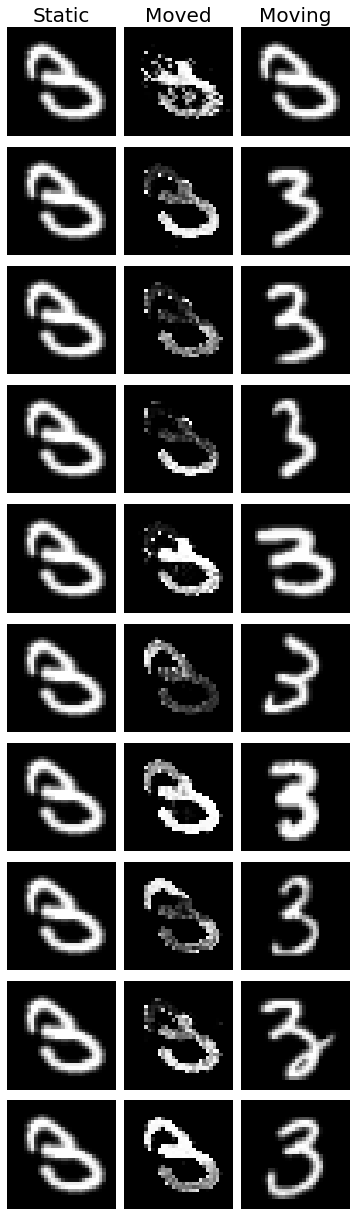

In [242]:
if __name__ == '__main__':

    class Args():
      batch_size = 8
      epochs = 10
      lr = 0.004
      label = 3  # which digit images to train on?
      num_samples = 10  # number of sample results to show
      save_model = False
    
    args = Args()
    print(model.summary())
    main(args,model)
    